# Logistic Regression

In this section, we will again test our accuracy, but this time with the logistic regression. Is it a strong model for this kind of data? Let's find out!

In [1]:
import os
import pandas as pd
import numpy as np

# Import train data
with np.load(os.path.join('processed_data', 'features_tr.npz'), allow_pickle=False) as data:
    features = dict(data.items())
X_tr = features['x']
y_tr = features['y']


# import validation data
with np.load(os.path.join('processed_data', 'features_va.npz'), allow_pickle=False) as data:
    features_va = dict(data.items())
X_va = features_va['x']
y_va = features_va['y']


#import test data
with np.load(os.path.join('processed_data', 'features_te.npz'), allow_pickle=False) as data:
    features_te = dict(data.items())
X_te = features_te['x']
y_te = features_te['y']

## Basic logistic regression model
We will start by testing a basic logistic regression model (without any hyperparameters tuning).

In [2]:
from sklearn.linear_model import LogisticRegression

# Create the estimator
logreg = LogisticRegression()

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on validation set
accuracy = logreg.score(X_va, y_va)
print('Accuracy: {:.3f}'.format(accuracy))

/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.921


Without doing anything, we already have an accuracy of 90%. Let's try to improve our accuracy with hyperparameters such as regularization strength or other methods. First, let's merge the train and validation data.

In [3]:
# merge train and validation data (for the Gridsearch cross-validation)
X = np.concatenate((X_tr, X_va), axis=0)
y = np.concatenate((y_tr, y_va), axis=0)

print("new data dimensions:{}".format(X.shape))
print("new data labels:{}".format(y.shape))

new data dimensions:(419, 2048)
new data labels:(419,)


Now we implement a Gridsearch Cross-Validation with the logistic regression by fine-tuning the weight of the Loss function (C) and the type of regression.

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Logistic regression estimator
logreg_estimator = Pipeline([
    ('logreg', LogisticRegression())
])

# Grid search with cross-validation
Cs = np.logspace(-4, 4, num=20)
grids = [{
    'logreg__multi_class': ['ovr'],
    'logreg__solver': ['liblinear'],
    'logreg__C': Cs
}, {
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['saga'],
    'logreg__C': Cs
}]
logreg_gscv = GridSearchCV(logreg_estimator, grids, cv=10, refit=True, return_train_score=True, verbose=1, n_jobs=2)

We can now fit our data and store the results.

In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Fit/evaluate estimator
logreg_gscv.fit(X, y)

# Collect results in a DataFrame
logreg_results = pd.DataFrame({
    'strategy': logreg_gscv.cv_results_['param_logreg__multi_class'],
    'C': logreg_gscv.cv_results_['param_logreg__C'],
    'mean_tr': logreg_gscv.cv_results_['mean_train_score'],
    'mean_te': logreg_gscv.cv_results_['mean_test_score'],
    'std_te': logreg_gscv.cv_results_['std_test_score']
})

# Ten best combinations according to the mean test score
logreg_results.sort_values(by='mean_te', ascending=False).head(10)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   40.3s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:  3.1min finished
/Users/valentinmonney/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,strategy,C,mean_tr,mean_te,std_te
26,multinomial,0.0335982,0.988863,0.937947,0.026236
27,multinomial,0.0885867,1.000000,0.937947,0.026236
25,multinomial,0.0127427,0.972949,0.933174,0.025228
6,ovr,0.0335982,0.987802,0.933174,0.023114
29,multinomial,0.615848,1.000000,0.933174,0.032926
36,multinomial,545.559,1.000000,0.930788,0.030634
35,multinomial,206.914,1.000000,0.930788,0.030634
5,ovr,0.0127427,0.964998,0.930788,0.023404
28,multinomial,0.233572,1.000000,0.930788,0.030634
30,multinomial,1.62378,1.000000,0.928401,0.029663


By fine-tuning the hyperparameters, we get an accuracy of ~94%, the best so far.

In [8]:
# Create the estimator
logreg_best = LogisticRegression(multi_class = 'multinomial', solver ='saga', C = 0.01)

# Fit it to train data
logreg_best.fit(X_tr, y_tr)

# Store the result
test_acurracy = logreg_best.score(X_te, y_te)
logistic_test_score = pd.DataFrame(data = {'model': ["logistic"], 'test_accuracy': [test_acurracy]})
%store logistic_test_score

Stored 'logistic_test_score' (DataFrame)


## Compute the probability for each class 

To further analyze our model, I will pick ten images and compute the probability for each class using the ```predict_proba()``` function of my estimator.

Found 139 images belonging to 6 classes.


,bike,car,motorcycle,other,truck,van
car-0074.png,0.037026,0.834927,0.026638,0.023677,0.025119,0.052614
van-0037.png,0.036563,0.257470,0.044971,0.131258,0.125647,0.404091
motorcycle-0063.png,0.008898,0.009456,0.948330,0.014414,0.012352,0.006549
truck-0049.png,0.018933,0.032289,0.017748,0.092698,0.805321,0.033011
car-0094.png,0.016929,0.928023,0.006141,0.028410,0.010767,0.009731
truck-0052.png,0.034602,0.034248,0.027023,0.052030,0.638323,0.213775
truck-0063.png,0.026051,0.036590,0.030193,0.091238,0.751382,0.064546
car-0086.png,0.019206,0.872630,0.016063,0.031835,0.014889,0.045377
truck-0048.png,0.021168,0.025434,0.016605,0.054973,0.830761,0.051057
bike-0098.png,0.959286,0.008059,0.007093,0.013669,0.006481,0.005411


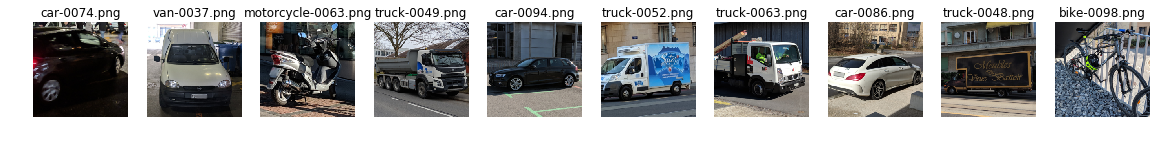

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.pyplot as plt
import random

# Extract images from validation set
image_generator = ImageDataGenerator(rescale=1/255) #Here we don't use extra transformation parameters because we have a validation set for this.
validset = image_generator.flow_from_directory(
    os.path.join('swissroads', 'valid'), target_size=(299, 299),
    shuffle=False, class_mode = 'sparse', batch_size = 280)

# Extract images and labels number 
images_valid, labels_valid = validset.next()

# Extract labels of classes
labels = validset.class_indices.keys()

# Select random images index
images_id = random.sample(range(0,139), 10)

# Extract names of images selected randomly
path = [validset.filepaths[i] for i in images_id]
image_names = []
for i in path:
    image_names.append(os.path.basename(i)) 

# Plot the ten random images
plt.figure(figsize = (20,2))
for i, idx in enumerate(images_id):
    plt.subplot(1, 10, i+1)
    plt.imshow(images_valid[idx])
    plt.title(image_names[i])
    plt.axis('off');
    
# Show the probabilities of labels for each image
logreg_best.predict_proba(X_va[images_id])

probabilities = pd.DataFrame(logreg_best.predict_proba(X_va[images_id]),
                columns=labels,
                index = image_names)
   
probabilities

### Variation of the regularization strength of my estimator
When we set a very small "C" (i.e. for very high regularization, remember "C" represents the inverse of the regularization strength in sklearn.), the probabilities become smoother, or less opinionated. This means all the 
6 probabilities converge to 1/6. However, with the right "C", the probabilities becomes stronger for one of the 6 classes which is supposed to represent the real class.
